# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [12]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [13]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [14]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [15]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [16]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [18]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [19]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [21]:
client = MongoClient(mongod_connect)
db = client.lab9 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [22]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [23]:
count = 100 #number of returned tweets, default and max is 100
geocode = "38.4392897,-78.9412224,50mi"  # defin the location, in Harrisonburg, VA
q = "election"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [24]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Wed Nov 09 20:26:26 +0000 2022'
'Wed Nov 09 20:24:07 +0000 2022'
'Wed Nov 09 20:22:45 +0000 2022'
'Wed Nov 09 20:21:03 +0000 2022'
'Wed Nov 09 20:08:04 +0000 2022'
'Wed Nov 09 20:06:47 +0000 2022'
'Wed Nov 09 20:06:07 +0000 2022'
'Wed Nov 09 20:05:01 +0000 2022'
'Wed Nov 09 19:54:02 +0000 2022'
'Wed Nov 09 19:51:02 +0000 2022'
'Wed Nov 09 19:49:02 +0000 2022'
'Wed Nov 09 19:44:26 +0000 2022'
'Wed Nov 09 19:39:25 +0000 2022'
'Wed Nov 09 19:39:25 +0000 2022'
'Wed Nov 09 19:37:28 +0000 2022'
'Wed Nov 09 19:33:27 +0000 2022'
'Wed Nov 09 19:29:36 +0000 2022'
'Wed Nov 09 19:16:39 +0000 2022'
'Wed Nov 09 19:16:07 +0000 2022'
'Wed Nov 09 19:15:15 +0000 2022'
'Wed Nov 09 19:08:52 +0000 2022'
'Wed Nov 09 19:03:54 +0000 2022'
'Wed Nov 09 19:03:14 +0000 2022'
'Wed Nov 09 19:01:08 +0000 2022'
'Wed Nov 09 18:58:50 +0000 2022'
'Wed Nov 09 18:57:22 +0000 2022'
'Wed Nov 09 18:55:36 +0000 2022'
'Wed Nov 09 18:53:00 +0000 2022'
'Wed Nov 09 18:47:31 +0000 2022'
'Wed Nov 09 18:37:38 +0000 2022'
'Wed Nov 0

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [25]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Wed Nov 09 16:27:48 +0000 2022'
'Wed Nov 09 16:24:57 +0000 2022'
'Wed Nov 09 16:23:46 +0000 2022'
'Wed Nov 09 16:23:44 +0000 2022'
'Wed Nov 09 16:23:02 +0000 2022'
'Wed Nov 09 16:21:32 +0000 2022'
'Wed Nov 09 16:20:28 +0000 2022'
'Wed Nov 09 16:20:17 +0000 2022'
'Wed Nov 09 16:18:56 +0000 2022'
'Wed Nov 09 16:14:28 +0000 2022'
'Wed Nov 09 16:13:48 +0000 2022'
'Wed Nov 09 16:12:08 +0000 2022'
'Wed Nov 09 16:06:12 +0000 2022'
'Wed Nov 09 16:01:50 +0000 2022'
'Wed Nov 09 15:59:13 +0000 2022'
'Wed Nov 09 15:57:31 +0000 2022'
'Wed Nov 09 15:57:23 +0000 2022'
'Wed Nov 09 15:53:55 +0000 2022'
'Wed Nov 09 15:53:12 +0000 2022'
'Wed Nov 09 15:48:18 +0000 2022'
'Wed Nov 09 15:42:35 +0000 2022'
'Wed Nov 09 15:32:04 +0000 2022'
'Wed Nov 09 15:29:04 +0000 2022'
'Wed Nov 09 15:27:34 +0000 2022'
'Wed Nov 09 15:25:49 +0000 2022'
'Wed Nov 09 15:25:36 +0000 2022'
'Wed Nov 09 15:21:38 +0000 2022'
'Wed Nov 09 15:21:16 +0000 2022'
'Wed Nov 09 15:18:59 +0000 2022'
'Wed Nov 09 15:17:25 +0000 2022'
'Wed Nov 0

'Wed Nov 09 03:16:34 +0000 2022'
'Wed Nov 09 03:15:53 +0000 2022'
'Wed Nov 09 03:12:27 +0000 2022'
'Wed Nov 09 03:12:23 +0000 2022'
'Wed Nov 09 03:12:22 +0000 2022'
'Wed Nov 09 03:10:32 +0000 2022'
'Wed Nov 09 03:07:43 +0000 2022'
'Wed Nov 09 03:07:40 +0000 2022'
'Wed Nov 09 03:03:37 +0000 2022'
'Wed Nov 09 03:03:29 +0000 2022'
'Wed Nov 09 03:01:33 +0000 2022'
'Wed Nov 09 03:00:16 +0000 2022'
'Wed Nov 09 02:59:43 +0000 2022'
'Wed Nov 09 02:57:53 +0000 2022'
'Wed Nov 09 02:56:50 +0000 2022'
'Wed Nov 09 02:55:23 +0000 2022'
'Wed Nov 09 02:55:02 +0000 2022'
'Wed Nov 09 02:54:49 +0000 2022'
'Wed Nov 09 02:54:28 +0000 2022'
'Wed Nov 09 02:54:12 +0000 2022'
'Wed Nov 09 02:53:33 +0000 2022'
'Wed Nov 09 02:52:47 +0000 2022'
'Wed Nov 09 02:51:51 +0000 2022'
'Wed Nov 09 02:47:02 +0000 2022'
'Wed Nov 09 02:46:24 +0000 2022'
'Wed Nov 09 02:43:43 +0000 2022'
'Wed Nov 09 02:43:41 +0000 2022'
'Wed Nov 09 02:39:04 +0000 2022'
'Wed Nov 09 02:38:51 +0000 2022'
'Wed Nov 09 02:38:03 +0000 2022'
'Wed Nov 0

'Tue Nov 08 20:51:06 +0000 2022'
'Tue Nov 08 20:44:02 +0000 2022'
'Tue Nov 08 20:41:40 +0000 2022'
'Tue Nov 08 20:41:35 +0000 2022'
'Tue Nov 08 20:41:21 +0000 2022'
'Tue Nov 08 20:36:02 +0000 2022'
'Tue Nov 08 20:32:40 +0000 2022'
'Tue Nov 08 20:31:42 +0000 2022'
'Tue Nov 08 20:31:41 +0000 2022'
'Tue Nov 08 20:31:18 +0000 2022'
'Tue Nov 08 20:30:14 +0000 2022'
'Tue Nov 08 20:28:14 +0000 2022'
'Tue Nov 08 20:25:01 +0000 2022'
'Tue Nov 08 20:21:18 +0000 2022'
'Tue Nov 08 20:16:42 +0000 2022'
'Tue Nov 08 20:16:21 +0000 2022'
'Tue Nov 08 20:15:52 +0000 2022'
'Tue Nov 08 20:14:04 +0000 2022'
'Tue Nov 08 20:11:52 +0000 2022'
'Tue Nov 08 20:10:11 +0000 2022'
'Tue Nov 08 20:09:01 +0000 2022'
'Tue Nov 08 20:04:50 +0000 2022'
'Tue Nov 08 20:04:47 +0000 2022'
'Tue Nov 08 20:04:38 +0000 2022'
'Tue Nov 08 20:02:00 +0000 2022'
'Tue Nov 08 20:00:02 +0000 2022'
'Tue Nov 08 19:58:57 +0000 2022'
'Tue Nov 08 19:58:55 +0000 2022'
'Tue Nov 08 19:57:17 +0000 2022'
'Tue Nov 08 19:56:41 +0000 2022'
'Tue Nov 0

'Tue Nov 08 13:40:51 +0000 2022'
'Tue Nov 08 13:37:40 +0000 2022'
'Tue Nov 08 13:37:33 +0000 2022'
'Tue Nov 08 13:36:00 +0000 2022'
'Tue Nov 08 13:33:02 +0000 2022'
'Tue Nov 08 13:32:58 +0000 2022'
'Tue Nov 08 13:32:02 +0000 2022'
'Tue Nov 08 13:30:02 +0000 2022'
'Tue Nov 08 13:29:59 +0000 2022'
'Tue Nov 08 13:27:58 +0000 2022'
'Tue Nov 08 13:27:13 +0000 2022'
'Tue Nov 08 13:26:20 +0000 2022'
'Tue Nov 08 13:23:54 +0000 2022'
'Tue Nov 08 13:18:03 +0000 2022'
'Tue Nov 08 13:16:31 +0000 2022'
'Tue Nov 08 13:14:25 +0000 2022'
'Tue Nov 08 13:11:01 +0000 2022'
'Tue Nov 08 13:08:36 +0000 2022'
'Tue Nov 08 13:07:53 +0000 2022'
'Tue Nov 08 13:07:51 +0000 2022'
'Tue Nov 08 13:04:30 +0000 2022'
'Tue Nov 08 13:01:55 +0000 2022'
'Tue Nov 08 13:01:10 +0000 2022'
'Tue Nov 08 13:00:55 +0000 2022'
'Tue Nov 08 13:00:22 +0000 2022'
'Tue Nov 08 13:00:01 +0000 2022'
'Tue Nov 08 12:59:14 +0000 2022'
'Tue Nov 08 12:56:29 +0000 2022'
'Tue Nov 08 12:54:16 +0000 2022'
'Tue Nov 08 12:52:23 +0000 2022'
'Tue Nov 0

'Mon Nov 07 19:06:15 +0000 2022'
'Mon Nov 07 19:06:11 +0000 2022'
'Mon Nov 07 19:05:00 +0000 2022'
'Mon Nov 07 19:01:22 +0000 2022'
'Mon Nov 07 18:57:40 +0000 2022'
'Mon Nov 07 18:46:10 +0000 2022'
'Mon Nov 07 18:46:09 +0000 2022'
'Mon Nov 07 18:45:16 +0000 2022'
'Mon Nov 07 18:41:32 +0000 2022'
'Mon Nov 07 18:39:23 +0000 2022'
'Mon Nov 07 18:15:22 +0000 2022'
'Mon Nov 07 18:12:40 +0000 2022'
'Mon Nov 07 18:11:33 +0000 2022'
'Mon Nov 07 18:09:50 +0000 2022'
'Mon Nov 07 18:09:48 +0000 2022'
'Mon Nov 07 18:09:33 +0000 2022'
'Mon Nov 07 18:08:17 +0000 2022'
'Mon Nov 07 18:07:00 +0000 2022'
'Mon Nov 07 18:02:44 +0000 2022'
'Mon Nov 07 18:01:11 +0000 2022'
'Mon Nov 07 17:55:31 +0000 2022'
'Mon Nov 07 17:51:00 +0000 2022'
'Mon Nov 07 17:49:26 +0000 2022'
'Mon Nov 07 17:45:44 +0000 2022'
'Mon Nov 07 17:44:55 +0000 2022'
'Mon Nov 07 17:39:50 +0000 2022'
'Mon Nov 07 17:30:57 +0000 2022'
'Mon Nov 07 17:27:43 +0000 2022'
'Mon Nov 07 17:20:14 +0000 2022'
'Mon Nov 07 17:19:33 +0000 2022'
'Mon Nov 0

'Sun Nov 06 03:24:22 +0000 2022'
'Sun Nov 06 03:20:29 +0000 2022'
'Sun Nov 06 03:10:47 +0000 2022'
'Sun Nov 06 02:43:59 +0000 2022'
'Sun Nov 06 02:07:18 +0000 2022'
'Sun Nov 06 02:07:02 +0000 2022'
'Sun Nov 06 01:57:21 +0000 2022'
'Sun Nov 06 01:53:55 +0000 2022'
'Sun Nov 06 01:51:43 +0000 2022'
'Sun Nov 06 01:50:49 +0000 2022'
'Sun Nov 06 01:25:33 +0000 2022'
'Sun Nov 06 01:21:40 +0000 2022'
'Sun Nov 06 01:19:07 +0000 2022'
'Sun Nov 06 01:17:30 +0000 2022'
'Sun Nov 06 00:53:11 +0000 2022'
'Sun Nov 06 00:48:10 +0000 2022'
'Sun Nov 06 00:02:33 +0000 2022'
'Sun Nov 06 00:00:13 +0000 2022'
'Sat Nov 05 23:57:45 +0000 2022'
'Sat Nov 05 23:53:23 +0000 2022'
'Sat Nov 05 23:45:03 +0000 2022'
'Sat Nov 05 23:44:15 +0000 2022'
'Sat Nov 05 23:39:07 +0000 2022'
'Sat Nov 05 23:33:56 +0000 2022'
'Sat Nov 05 23:24:13 +0000 2022'
'Sat Nov 05 23:17:08 +0000 2022'
'Sat Nov 05 22:56:47 +0000 2022'
'Sat Nov 05 22:50:30 +0000 2022'
'Sat Nov 05 22:22:55 +0000 2022'
'Sat Nov 05 22:18:11 +0000 2022'
'Sat Nov 0

'Fri Nov 04 15:03:24 +0000 2022'
'Fri Nov 04 15:03:04 +0000 2022'
'Fri Nov 04 15:00:17 +0000 2022'
'Fri Nov 04 15:00:09 +0000 2022'
'Fri Nov 04 14:57:55 +0000 2022'
'Fri Nov 04 14:48:04 +0000 2022'
'Fri Nov 04 14:38:43 +0000 2022'
'Fri Nov 04 14:27:17 +0000 2022'
'Fri Nov 04 14:23:44 +0000 2022'
'Fri Nov 04 14:17:18 +0000 2022'
'Fri Nov 04 14:04:17 +0000 2022'
'Fri Nov 04 14:00:52 +0000 2022'
'Fri Nov 04 14:00:05 +0000 2022'
'Fri Nov 04 14:00:04 +0000 2022'
'Fri Nov 04 13:59:01 +0000 2022'
'Fri Nov 04 13:53:55 +0000 2022'
'Fri Nov 04 13:51:01 +0000 2022'
'Fri Nov 04 13:45:57 +0000 2022'
'Fri Nov 04 13:27:59 +0000 2022'
'Fri Nov 04 13:25:01 +0000 2022'
'Fri Nov 04 13:15:02 +0000 2022'
'Fri Nov 04 13:14:38 +0000 2022'
'Fri Nov 04 13:10:59 +0000 2022'
'Fri Nov 04 13:03:13 +0000 2022'
'Fri Nov 04 12:51:06 +0000 2022'
'Fri Nov 04 12:36:46 +0000 2022'
'Fri Nov 04 12:36:29 +0000 2022'
'Fri Nov 04 12:36:13 +0000 2022'
'Fri Nov 04 12:09:13 +0000 2022'
'Fri Nov 04 11:48:51 +0000 2022'
'Fri Nov 0

'Thu Nov 03 04:31:55 +0000 2022'
'Thu Nov 03 04:25:39 +0000 2022'
'Thu Nov 03 04:23:04 +0000 2022'
'Thu Nov 03 04:10:01 +0000 2022'
'Thu Nov 03 04:09:17 +0000 2022'
'Thu Nov 03 04:04:03 +0000 2022'
'Thu Nov 03 03:54:30 +0000 2022'
'Thu Nov 03 03:53:33 +0000 2022'
'Thu Nov 03 03:46:54 +0000 2022'
'Thu Nov 03 03:32:38 +0000 2022'
'Thu Nov 03 03:31:53 +0000 2022'
'Thu Nov 03 03:30:51 +0000 2022'
'Thu Nov 03 03:26:48 +0000 2022'
'Thu Nov 03 03:05:22 +0000 2022'
'Thu Nov 03 02:59:52 +0000 2022'
'Thu Nov 03 02:58:48 +0000 2022'
'Thu Nov 03 02:53:11 +0000 2022'
'Thu Nov 03 02:50:04 +0000 2022'
'Thu Nov 03 02:46:36 +0000 2022'
'Thu Nov 03 02:45:57 +0000 2022'
'Thu Nov 03 02:43:01 +0000 2022'
'Thu Nov 03 02:39:25 +0000 2022'
'Thu Nov 03 02:38:13 +0000 2022'
'Thu Nov 03 02:36:49 +0000 2022'
'Thu Nov 03 02:33:44 +0000 2022'
'Thu Nov 03 02:31:16 +0000 2022'
'Thu Nov 03 02:19:30 +0000 2022'
'Thu Nov 03 02:19:27 +0000 2022'
'Thu Nov 03 02:15:29 +0000 2022'
'Thu Nov 03 02:14:45 +0000 2022'
'Thu Nov 0

'Tue Nov 01 14:22:41 +0000 2022'
'Tue Nov 01 14:14:14 +0000 2022'
'Tue Nov 01 14:06:35 +0000 2022'
'Tue Nov 01 14:04:20 +0000 2022'
'Tue Nov 01 14:00:01 +0000 2022'
'Tue Nov 01 13:58:40 +0000 2022'
'Tue Nov 01 13:57:25 +0000 2022'
'Tue Nov 01 13:45:24 +0000 2022'
'Tue Nov 01 13:41:05 +0000 2022'
'Tue Nov 01 13:30:05 +0000 2022'
'Tue Nov 01 13:14:38 +0000 2022'
'Tue Nov 01 13:09:44 +0000 2022'
'Tue Nov 01 13:04:07 +0000 2022'
'Tue Nov 01 13:01:32 +0000 2022'
'Tue Nov 01 13:00:37 +0000 2022'
'Tue Nov 01 12:45:32 +0000 2022'
'Tue Nov 01 12:44:59 +0000 2022'
'Tue Nov 01 12:42:28 +0000 2022'
'Tue Nov 01 12:36:18 +0000 2022'
'Tue Nov 01 12:25:12 +0000 2022'
'Tue Nov 01 12:10:59 +0000 2022'
'Tue Nov 01 12:04:51 +0000 2022'
'Tue Nov 01 11:52:02 +0000 2022'
'Tue Nov 01 11:48:52 +0000 2022'
'Tue Nov 01 11:47:02 +0000 2022'
'Tue Nov 01 11:41:33 +0000 2022'
'Tue Nov 01 11:38:26 +0000 2022'
'Tue Nov 01 11:35:17 +0000 2022'
'Tue Nov 01 11:19:37 +0000 2022'
'Tue Nov 01 11:02:49 +0000 2022'
'Tue Nov 0

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [26]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

2277
1016


Create a text index and print the Tweets containing specific keywords. 

In [27]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [10]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [11]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: mark
text: RT @Mia4MD: Early Voting is happening NOW in Maryland for the 2020 Presidential Election. You can vote in an early voting center in the cou…
----
name: megaminimalist
text: RT @Amy_Siskind: TEXAS‼️ - an astounding 7.8 million Texans have voted!  That’s 88% of all the 2016 votes. 

There is little mail-in voting…
----
name: Virginians4U
text: KEEP Pres: TRUMP
CHANGE Senate: GADE
HOPE Congress GOOD or FREITAS or TAYLOR or BENJAMIN or ANDREWS 
VOTE VOTE VOTE… https://t.co/2ZjF6E0Blv
----
name: Antonio Licon
text: #VOTE
----
name: jtevans
text: #Vote
----
name: Toto
text: RT @grantstern: Why is ⁦@MayorGimenez⁩ against social distancing during voting in #Miami?

Because he knows that suppressing the vote will…
----
name: Kiran Riar
text: RT @raquelmiranda89: Shelby County: you have today and tomorrow to early vote. That is it! After Thursday, your last chance to vote in pers…
----
name: Kirby Mendyk
text: I'm not voting until a celebrity tweets a picture of their taint

In [12]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [13]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,lang,timestamp_ms,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet,possibly_sensitive,metadata,display_text_range
0,5f9970e6ea281243abe9e85f,Wed Oct 28 13:23:45 +0000 2020,1321442530572066817,1321442530572066817,RT @Mia4MD: Early Voting is happening NOW in M...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891425160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f9970eaea281243abe9e8c9,Wed Oct 28 13:23:49 +0000 2020,1321442549718945792,1321442549718945792,RT @Amy_Siskind: TEXAS‼️ - an astounding 7.8 m...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891429725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f9970efea281243abe9e939,Wed Oct 28 13:23:54 +0000 2020,1321442568459198467,1321442568459198467,KEEP Pres: TRUMP\nCHANGE Senate: GADE\nHOPE Co...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,...,en,1603891434193,1.321379e+18,1321378894327484416,{'created_at': 'Wed Oct 28 09:10:53 +0000 2020...,"{'url': 'https://t.co/g07jyouj2s', 'expanded':...",{'full_text': 'KEEP Pres: TRUMP CHANGE Senate:...,NaN,NaN,NaN
3,5f997133ea281243abe9ea5a,Wed Oct 28 13:25:02 +0000 2020,1321442853244018690,1321442853244018690,#VOTE,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,und,1603891502091,1.321441e+18,1321440905098874882,{'created_at': 'Wed Oct 28 13:17:17 +0000 2020...,"{'url': 'https://t.co/SiYtZzvyXq', 'expanded':...",NaN,NaN,NaN,NaN
4,5f9970e6ea281243abe9e868,Wed Oct 28 13:23:45 +0000 2020,1321442531532435457,1321442531532435457,#Vote,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,und,1603891425389,1.321180e+18,1321179867052986368,{'created_at': 'Tue Oct 27 20:00:01 +0000 2020...,"{'url': 'https://t.co/VhdpN9qfYf', 'expanded':...",NaN,NaN,NaN,NaN
5,5f9970f5ea281243abe9e9b4,Wed Oct 28 13:24:00 +0000 2020,1321442594174455809,1321442594174455809,RT @grantstern: Why is ⁦@MayorGimenez⁩ against...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,en,1603891440324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5f9970eaea281243abe9e8c6,Wed Oct 28 13:23:49 +0000 2020,1321442549379334144,1321442549379334144,RT @raquelmiranda89: Shelby County: you have t...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891429644,1.316336e+18,1316335746702340097,{'created_at': 'Wed Oct 14 11:11:13 +0000 2020...,"{'url': 'https://t.co/AbysBKfi2s', 'expanded':...",NaN,NaN,NaN,NaN
7,5f9970f9ea281243abe9ea15,Wed Oct 28 13:24:04 +0000 2020,1321442610347737088,1321442610347737088,I'm not voting until a celebrity tweets a pict...,"<a href=""http://twitter.com/download/android"" ...",True,NaN,None,NaN,...,en,1603891444180,NaN,NaN,NaN,NaN,{'full_text': 'I'm not voting until a celebrit...,NaN,NaN,NaN
8,5f997133ea281243abe9ea5b,Wed Oct 28 13:25:02 +0000 2020,1321442853617164289,1321442853617164289,RT @kkjjPNW: You do not have to vote by mail i...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891502180,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
9,5f9970faea281243abe9ea39,Wed Oct 28 13:24:05 +0000 2020,1321442617138286594,1321442617138286594,RT @Carnage4Life: It’s easier for a white pers...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,en,1603891445799,1.320028e+18,1320027534789140480,{'created_at': 'Sat Oct 24 15:41:03 +0000 2020...,"{'url': 'https://t.co/8u0q776vmb', 'expanded':...",NaN,NaN,NaN,NaN


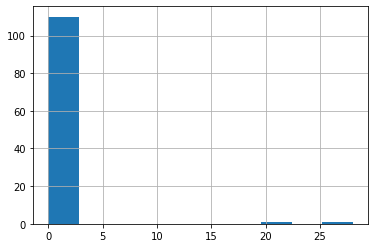

In [14]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count